# Replication of Lutzke (2019)

Replicating effect as baseline case.

There were many effects presented in this paper but I will aim to only investigate these significant causal quantities of interests for simplicity's sake:

- What is the enhanced guideline's treatment effect on reducing likelihood to share a fake news facebook post? (share_post)
- What is the enhanced guideline's treatment effect on reducing the trust in a fake news facebook post? (trust_post)

We will start however by trying to replicate the main effects presented as a way to fact check the paper and the dataset.

In [0]:
# imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.utils import resample


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_raw = pd.read_csv('drive/My Drive/Causal Inference Project/Lutzke_2019/Data_GEC.csv', encoding='ISO-8859-1')

print(data_raw.columns)
data_raw.describe()
data_raw.dtypes

Index(['Deleted Responses', 'Condition', 'Article', 'Consent', 'Consent2',
       'HaveFacebook?', 'Believe in climate change?', 'Believer or Doubter',
       'Post trustworthy?', 'Post accurate?', 'Would you like the post?',
       'Would you share the post?', 'Recognize source?',
       'Burning oil produces CO2',
       'Nuclear power plants emit CO2Êduring operation.',
       'At the same quantity, CO2Êis more harmful to the climate than methane.Ê',
       'The global CO2Êconcentration in the atmosphere has increased during the past 250 years.Ê',
       'Climate change is mainly caused by human activities.',
       'The last century's global increase in temperature was the largest during the past 1,000 years.',
       'TodayÕs global CO2Êconcentration in the atmosphere has already occurred in the past 650,000 years.',
       'Climate scientists expect a warmer climate to increase the melting of polar ice, which will lead to an overall rise of the sea level.',
       'Climate scient

Deleted Responses                                                                                                                         object
Condition                                                                                                                                 object
Article                                                                                                                                   object
Consent                                                                                                                                   object
Consent2                                                                                                                                  object
HaveFacebook?                                                                                                                             object
Believe in climate change?                                                                                                        

Index(['Deleted Responses', 'Condition', 'Article', 'Consent', 'Consent2',
       'HaveFacebook?', 'Believe in climate change?', 'Believer or Doubter',
       'Post trustworthy?', 'Post accurate?', 'Would you like the post?',
       'Would you share the post?', 'Recognize source?',
       'Burning oil produces CO2',
       'Nuclear power plants emit CO2Êduring operation.',
       'At the same quantity, CO2Êis more harmful to the climate than methane.Ê',
       'The global CO2Êconcentration in the atmosphere has increased during the past 250 years.Ê',
       'Climate change is mainly caused by human activities.',
       'The last century's global increase in temperature was the largest during the past 1,000 years.',
       'TodayÕs global CO2Êconcentration in the atmosphere has already occurred in the past 650,000 years.',
       'Climate scientists expect a warmer climate to increase the melting of polar ice, which will lead to an overall rise of the sea level.',
       'Climate scient

Deleted Responses                                                                                                                         object
Condition                                                                                                                                 object
Article                                                                                                                                   object
Consent                                                                                                                                   object
Consent2                                                                                                                                  object
HaveFacebook?                                                                                                                             object
Believe in climate change?                                                                                                        

In [0]:
# Rename columns
names = ['deleted_responses', 'condition', 'article', 'consent', 'consent2', 'have_facebook_q', 'believe_climate_change_q',\
         'believer_doubter', 'post_trustworthy', 'post_accurate', 'like_post', 'share_post', \
         'recognize_source', 'burning_oil_co2', 'nuclear_power_co2', \
         'co2_methane', 'global_co2_increase', 'climate_change_human_activities',\
         'last_century_global_increase', 'today_concentration_already_occured', \
         'scientists_expect_warming_increase_melting',\
         'scientists_expect_increase_extreme_events',\
         'scientists_expect_increase_water_evap',\
         'scientists_expect_climate_change_evenly',\
         'feelings_toward_fb', 'gender', 'gender_text',\
         'age', 'education', 'politics',\
         'politics_text', 'conservative']
data_clean = data_raw.copy()
data_clean.columns = names
data_clean.to_csv('drive/My Drive/Causal Inference Project/Lutzke_2019/Data_GEC_python_friendly.csv')
# Remove deleted responses (keep those with NA in deleted_responses)
data_clean = data_clean[data_clean['deleted_responses'].isna()]
# Create post_type
data_clean = data_clean.assign(\
    post_type = lambda dataframe: dataframe['article'].\
    map(lambda article:\
        'Fake' if article == 'Breitbart' or\
        article == 'Natural News' or\
        article == 'InfoWars' \
        else 'Real'))
print(data_clean.columns)
data_clean.post_type.astype('category')
data_clean.condition.astype('category')
data_clean.shape

Index(['deleted_responses', 'condition', 'article', 'consent', 'consent2',
       'have_facebook_q', 'believe_climate_change_q', 'believer_doubter',
       'post_trustworthy', 'post_accurate', 'like_post', 'share_post',
       'recognize_source', 'burning_oil_co2', 'nuclear_power_co2',
       'co2_methane', 'global_co2_increase', 'climate_change_human_activities',
       'last_century_global_increase', 'today_concentration_already_occured',
       'scientists_expect_warming_increase_melting',
       'scientists_expect_increase_extreme_events',
       'scientists_expect_increase_water_evap',
       'scientists_expect_climate_change_evenly', 'feelings_toward_fb',
       'gender', 'gender_text', 'age', 'education', 'politics',
       'politics_text', 'conservative', 'post_type'],
      dtype='object')


(2750, 33)

Index(['deleted_responses', 'condition', 'article', 'consent', 'consent2',
       'have_facebook_q', 'believe_climate_change_q', 'believer_doubter',
       'post_trustworthy', 'post_accurate', 'like_post', 'share_post',
       'recognize_source', 'burning_oil_co2', 'nuclear_power_co2',
       'co2_methane', 'global_co2_increase', 'climate_change_human_activities',
       'last_century_global_increase', 'today_concentration_already_occured',
       'scientists_expect_warming_increase_melting',
       'scientists_expect_increase_extreme_events',
       'scientists_expect_increase_water_evap',
       'scientists_expect_climate_change_evenly', 'feelings_toward_fb',
       'gender', 'gender_text', 'age', 'education', 'politics',
       'politics_text', 'conservative', 'post_type'],
      dtype='object')


(2750, 33)

In [0]:
print(set(data_clean[data_clean.post_type == 'Fake'].article))
print(set(data_clean[data_clean.post_type == 'Real'].article))
print(set(data_clean.condition))
data_clean.describe()

{'Breitbart', 'InfoWars', 'Natural News'}
{'NASA', 'Scientific American', 'USA Today'}
{'Control', 'Enhanced Guidelines', 'Guidelines'}


,post_trustworthy,post_accurate,like_post,share_post,feelings_toward_fb,age
count,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000
mean,5.256182,5.342655,-0.785127,-1.116255,0.269127,44.933455
std,2.795857,2.775415,3.341250,3.296836,2.474546,40.327248
min,1.000000,1.000000,-5.000000,-5.000000,-5.000000,4.000000
25%,2.900000,3.000000,-4.200000,-4.700000,-1.500000,32.000000
50%,5.300000,5.400000,-0.500000,-1.200000,0.000000,42.000000
75%,7.500000,7.600000,2.000000,1.400000,2.200000,56.000000
max,10.000000,10.000000,5.000000,5.000000,5.000000,1964.000000


{'Breitbart', 'InfoWars', 'Natural News'}
{'NASA', 'Scientific American', 'USA Today'}
{'Control', 'Enhanced Guidelines', 'Guidelines'}


,post_trustworthy,post_accurate,like_post,share_post,feelings_toward_fb,age
count,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000
mean,5.256182,5.342655,-0.785127,-1.116255,0.269127,44.933455
std,2.795857,2.775415,3.341250,3.296836,2.474546,40.327248
min,1.000000,1.000000,-5.000000,-5.000000,-5.000000,4.000000
25%,2.900000,3.000000,-4.200000,-4.700000,-1.500000,32.000000
50%,5.300000,5.400000,-0.500000,-1.200000,0.000000,42.000000
75%,7.500000,7.600000,2.000000,1.400000,2.200000,56.000000
max,10.000000,10.000000,5.000000,5.000000,5.000000,1964.000000


In [0]:
# trust is an average of trustworthy and accurate
data_clean['post_trust'] = (data_clean['post_trustworthy'] + data_clean['post_accurate'])/2

# sharing metric was converted from [-5 to 5] to [1 to 11]
data_clean['share_post'] = data_clean['share_post'] + 6
data_clean.to_csv('drive/My Drive/Causal Inference Project/Lutzke_2019/Data_GEC_clean_python_friendly.csv')

Recreate the results running the anova test (descriptives and tests). Only did this for sharing and trust since those were significant effects.

In [0]:
print("\n\n Trust =================\n")
print(data_clean.groupby(by = ['post_type', 'condition']).post_trust.describe())
print("\n\n")
formula = 'post_trust ~ C(post_type) + C(condition) + C(post_type):C(condition)'
model = ols(formula, data_clean).fit()
trust_table = anova_lm(model, typ=1)
print(trust_table)

print("\n\n Share =================\n")
print(data_clean.groupby(by = ['post_type', 'condition']).share_post.describe())
print("\n\n")
formula = 'share_post ~ C(post_type) + C(condition) + C(post_type):C(condition)'
model = ols(formula, data_clean).fit()
share_table = anova_lm(model, typ=1)
print(share_table)




 Trust =================

                               count      mean       std  ...    50%   75%   max
post_type condition                                       ...                   
Fake      Control              477.0  4.276625  2.550180  ...  4.000  6.05  10.0
          Enhanced Guidelines  456.0  4.029605  2.437690  ...  3.775  5.80  10.0
          Guidelines           464.0  3.932220  2.597085  ...  3.175  5.65  10.0
Real      Control              457.0  6.376039  2.341511  ...  6.450  8.20  10.0
          Enhanced Guidelines  443.0  6.604853  2.267273  ...  6.850  8.25  10.0
          Guidelines           453.0  6.692274  2.397770  ...  7.100  8.55  10.0

[6 rows x 8 columns]



                               df        sum_sq  ...           F         PR(>F)
C(post_type)                  1.0   4211.082600  ...  709.206750  3.527257e-139
C(condition)                  2.0      0.191559  ...    0.016131   9.839988e-01
C(post_type):C(condition)     2.0     53.806747  ...    4.5

Let's take this one step further and get actual estimates for the treatment effect for our quantities of interest, find confidence bounds and significance values based on bootstrap methodology.

In [0]:
data_fake = data_clean[data_clean.post_type == 'Fake']
bootstrap_fn = lambda x: pd.DataFrame(x.values[np.random.randint(len(x), 
                                                                 size=len(x))], 
                                      columns=x.columns)
bootstraps = [bootstrap_fn(data_fake) for i in range(0, 1000)]



Trust Fake (Control) ==========


{'upper 95% CI': 4.500589433886508, 'lower 95% CI': 4.063963886505087, 'median': 4.270298898804991, 'max': 4.599671052631573, 'min': 3.8786016949152553}


Trust Fake (Enhanced Guidelines) ==========


{'upper 95% CI': 4.238327884709575, 'lower 95% CI': 3.804047099615305, 'median': 4.02715249554497, 'max': 4.385609243697475, 'min': 3.6906320541760724}


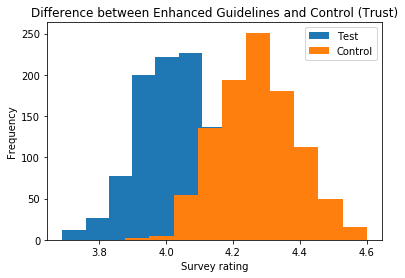



Share Fake (Control) ==========


{'upper 95% CI': 4.798305885062765, 'lower 95% CI': 4.2081405756405745, 'median': 4.512795220037038, 'max': 5.111482254697287, 'min': 4.007337526205454}


Share Fake (Enhanced Guidelines) ==========


{'upper 95% CI': 4.046330232306362, 'lower 95% CI': 3.5073145776996375, 'median': 3.769219694788365, 'max': 4.298823529411763, 'min': 3.267375886524821}


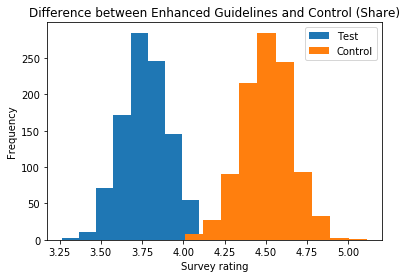

In [0]:
#@title Default title text
mean_trust_enguideline_bs = np.array([df.post_trust[df.condition == 'Enhanced Guidelines'].mean() for df in bootstraps])
mean_trust_control_bs = np.array([df.post_trust[df.condition == 'Control'].mean() for df in bootstraps])

mean_share_enguideline_bs = np.array([df.share_post[df.condition == 'Enhanced Guidelines'].mean() for df in bootstraps])
mean_share_control_bs = np.array([df.share_post[df.condition == 'Control'].mean() for df in bootstraps])

def calculate_distribution(np_array):
  # calculate 95% conf interval (2-sided)
  upper_95 = np.quantile(np_array, 0.975)
  lower_95 = np.quantile(np_array, 0.025)
  # median point estimate
  median = np.quantile(np_array, 0.5)
  # max val
  max_val = np.max(np_array)
  min_val = np.min(np_array)
  return {'upper 95% CI': upper_95,\
          'lower 95% CI': lower_95,\
          'median': median,\
          'max': max_val,\
          'min': min_val}

print("\n\nTrust Fake (Control) ==========\n\n")
print(calculate_distribution(mean_trust_control_bs))
print("\n\nTrust Fake (Enhanced Guidelines) ==========\n\n")
print(calculate_distribution(mean_trust_enguideline_bs))
plt.title ("Difference between Enhanced Guidelines and Control (Trust)")
plt.xlabel("Survey rating")
plt.ylabel("Frequency")
plt.hist(mean_trust_enguideline_bs)
plt.hist(mean_trust_control_bs)
plt.legend(['Test', 'Control'])
plt.show()

print("\n\nShare Fake (Control) ==========\n\n")
print(calculate_distribution(mean_share_control_bs))
print("\n\nShare Fake (Enhanced Guidelines) ==========\n\n")
print(calculate_distribution(mean_share_enguideline_bs))
plt.title ("Difference between Enhanced Guidelines and Control (Share)")
plt.xlabel("Survey rating")
plt.ylabel("Frequency")
plt.hist(mean_share_enguideline_bs)
plt.hist(mean_share_control_bs)
plt.legend(['Test', 'Control'])
plt.show()
#Find the probability of seeing the test data given control


In [0]:
# Creates normal KDEs out of two distributions and finds % overlap
def intersect_two_normal(data1, data2):

    def prob_value(bins, mu, sigma):
        output = 1/(sigma * np.sqrt(2 * np.pi))
        output *= np.exp( - (bins - mu)**2 / (2 * sigma**2))
        return output
    
    # mean, s.e.
    mu_s, sigma_s = np.mean(data1), np.std(data1)
    mu_pos, sigma_pos = np.mean(data2), np.std(data2)
    
    # probability of given bins value
    bins = np.arange(min(min(data1), min(data2)), 
                     max(max(data1), max(data2))+0.01, 0.1)
    value_s = prob_value(bins, mu_s, sigma_s)
    value_pos = prob_value(bins, mu_pos, sigma_pos)                                    

    # calcuate overlap
    overlap = 0
    for i, b in enumerate(bins):
        overlap+= min(value_s[i], value_pos[i])*0.1
    
    # draw plot
    plt.hist(data1, 10, density=True)
    plt.plot(bins, value_s, linewidth=2, color='r', label="data1")
    plt.hist(data2, 10, density=True)
    plt.plot(bins, value_pos, linewidth=2, color='g', label="data2")
    plt.legend()
    
    return overlap
  


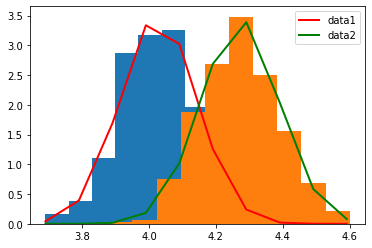

In [0]:
# test intersect_two_normal
# creates normal KDE to find % overlap
overlap = intersect_two_normal(mean_trust_enguideline_bs, mean_trust_control_bs)

In [0]:
# Also calculate p-value in the traditional way: probability of observing the test estimate or more extreme within the control distribution

# calculate # of control simulations below test estimate out of all control simulations
test_estimate = np.quantile(mean_trust_enguideline_bs, 0.5)
p_value = len([i for i in mean_trust_control_bs if i <= test_estimate])/len(mean_trust_control_bs)
print("overlap is: ", round(overlap, 3))
print("p-value is: ", p_value)


overlap is:  0.273
p-value is:  0.008


In [0]:
data_clean.columns

Index(['deleted_responses', 'condition', 'article', 'consent', 'consent2',
       'have_facebook_q', 'believe_climate_change_q', 'believer_doubter',
       'post_trustworthy', 'post_accurate', 'like_post', 'share_post',
       'recognize_source', 'burning_oil_co2', 'nuclear_power_co2',
       'co2_methane', 'global_co2_increase', 'climate_change_human_activities',
       'last_century_global_increase', 'today_concentration_already_occured',
       'scientists_expect_warming_increase_melting',
       'scientists_expect_increase_extreme_events',
       'scientists_expect_increase_water_evap',
       'scientists_expect_climate_change_evenly', 'feelings_toward_fb',
       'gender', 'gender_text', 'age', 'education', 'politics',
       'politics_text', 'conservative', 'post_type', 'post_trust'],
      dtype='object')

In [0]:
# DON'T RERUN - CREATES THE MISSING COVARIATE DATASETS
# create function to randomize missing data points
# Sensitivity to different levels of missingness:
# [10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%]

def create_missing_points(data, percent_missing, covariate_names):
  """ 
  This function WILL modify data. Please make a
  copy before passing into this function

  data: a pandas dataframe
  percent_missing: float, % of points missing
  covariate_names: list of strings, names of covariates to insert missing values,
  must be present in data 
  """
  data = data.copy()
  for covariate in covariate_names:
    print("Working on column: ", covariate)
    data = data.sample(frac=1).reset_index(drop=True)
    for i in range(0, len(data)):
      if i <= percent_missing*len(data):
        data.loc[i, covariate] = None 
  return data


covariate_names = ["have_facebook_q",\
                    "believe_climate_change_q",\
                    "believer_doubter",\
                    "burning_oil_co2",\
                    "nuclear_power_co2",\
                    "co2_methane",\
                    "global_co2_increase",\
                    "climate_change_human_activities",\
                    "last_century_global_increase",\
                    "today_concentration_already_occured",\
                    'scientists_expect_warming_increase_melting',\
                    'scientists_expect_increase_extreme_events',\
                    'scientists_expect_increase_water_evap',\
                    'scientists_expect_climate_change_evenly',\
                    'feelings_toward_fb',\
                    'gender', 'age', 'education',\
                    'politics', 'conservative']

# data_clean_missing_10 = data_clean.copy()
# data_clean_missing_10 = create_missing_points(data_clean_missing_10,\
#                                              .1,\
#                                              covariate_names)
# data_clean_missing_10.head()

for percent in [.1, .2, .3, .4, .5, .6, .7, .8]:
  data_clean_missing = create_missing_points(data_clean,\
                                              percent,\
                                              covariate_names)
  data_clean_missing.to_csv('drive/My Drive/Causal Inference Project/Lutzke_2019/data_clean_missing' + str(int(percent*100)) + '.csv', index=False)


Working on column:  have_facebook_q
Working on column:  believe_climate_change_q
Working on column:  believer_doubter
Working on column:  burning_oil_co2
Working on column:  nuclear_power_co2
Working on column:  co2_methane
Working on column:  global_co2_increase
Working on column:  climate_change_human_activities
Working on column:  last_century_global_increase
Working on column:  today_concentration_already_occured
Working on column:  scientists_expect_warming_increase_melting
Working on column:  scientists_expect_increase_extreme_events
Working on column:  scientists_expect_increase_water_evap
Working on column:  scientists_expect_climate_change_evenly
Working on column:  feelings_toward_fb
Working on column:  gender
Working on column:  age
Working on column:  education
Working on column:  politics
Working on column:  conservative
Working on column:  have_facebook_q
Working on column:  believe_climate_change_q
Working on column:  believer_doubter
Working on column:  burning_oil_co2


In [0]:
#Check that it worked
data_check = pd.read_csv('drive/My Drive/Causal Inference Project/Lutzke_2019/data_clean_missing80.csv', encoding='ISO-8859-1')
sum(data_check["have_facebook_q"].isna())
for covariate in covariate_names:
  print(covariate,":", str(sum(data_check[covariate].isna())/len(data_check)))

# check completeneess of base data
# for covariate in covariate_names:
#   print(covariate,":", str(sum(data_clean[covariate].isna())/len(data_clean)))

have_facebook_q : 0.8003636363636364
believe_climate_change_q : 0.8003636363636364
believer_doubter : 0.8003636363636364
burning_oil_co2 : 0.8003636363636364
nuclear_power_co2 : 0.8003636363636364
co2_methane : 0.8003636363636364
global_co2_increase : 0.8003636363636364
climate_change_human_activities : 0.8003636363636364
last_century_global_increase : 0.8003636363636364
today_concentration_already_occured : 0.8003636363636364
scientists_expect_warming_increase_melting : 0.8003636363636364
scientists_expect_increase_extreme_events : 0.8003636363636364
scientists_expect_increase_water_evap : 0.8003636363636364
scientists_expect_climate_change_evenly : 0.8003636363636364
feelings_toward_fb : 0.8003636363636364
gender : 0.8003636363636364
age : 0.8003636363636364
education : 0.8003636363636364
politics : 0.8003636363636364
conservative : 0.8003636363636364
